# 5-1. 결정 트리

## 로지스틱 회귀로 와인 분류하기
- 알코올 도수, 당도, pH 값에 로지스틱 회귀 모델을 적용하여 주어진 샘플에 대해 와인 종류를 구별하기


In [ ]:
#kaggle의 데이터셋
import pandas as pd
wine = pd.read_csv("https://bit.ly/wine_csv_data")

In [ ]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


이진 분류 문제 : red wine(0) vs white wine(1) \
pandas 내 유용한 method :
1. **info()** : dataframe의 각 열 데이터 타입과 누락된 데이터가 있는지 확인하는 데 유용
2. **describe()** : col data에 대해 간단한 통계를 출력(개수, min, max, median, quantile)

In [ ]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [ ]:
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [ ]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

# train vs test
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)
# test_size의 default는 0.25
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


In [ ]:
# 표준화 처리
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [ ]:
# 로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7808350971714451
0.7776923076923077


낮은 스코어의 원인을 찾아야 함 : parameter C? solver? 다항특성 추가?

LogisticRegression의 단점은 직관적으로 설명하기 어렵다는 것 -> 결정 트리의 필요성

## 결정 트리
- 순서도를 통해 분류하므로 직관적으로 이해하기 쉬움
- sklearn의 DecisionTreeClassifier 클래스 사용
- 표준화 전처리가 필요하지 않음

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.996921300750433
0.8592307692307692


test score << train_score : 과대적합 상황

In [ ]:
# sklearn의 plot_tree method를 통해 결정 트리를 그림으로 출력
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(15,10))
plot_tree(dt)
plt.show()


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fecfa1c2320> (for post_execute):


KeyboardInterrupt: ignored

- node : 결정 트리를 구성하는 핵심 요소, 훈련 데이터의 특성에 대한 테스트를 표현
- branch : 테스트의 결과를 T or F로 나타나며 하나의 node는 2개의 branch를 가짐
- root node : tree 내 가장 위 노드
- leaf node : tree 내 가장 아래 노드

plot_tree()의 parameter
- **max_depth** : plot_tree()에서 트리의 깊이depth를 제한해서 출력가능
- **filled** : 클래스에 맞게 노드의 색 지정
- **feature_names** : 특성의 이름을 지정

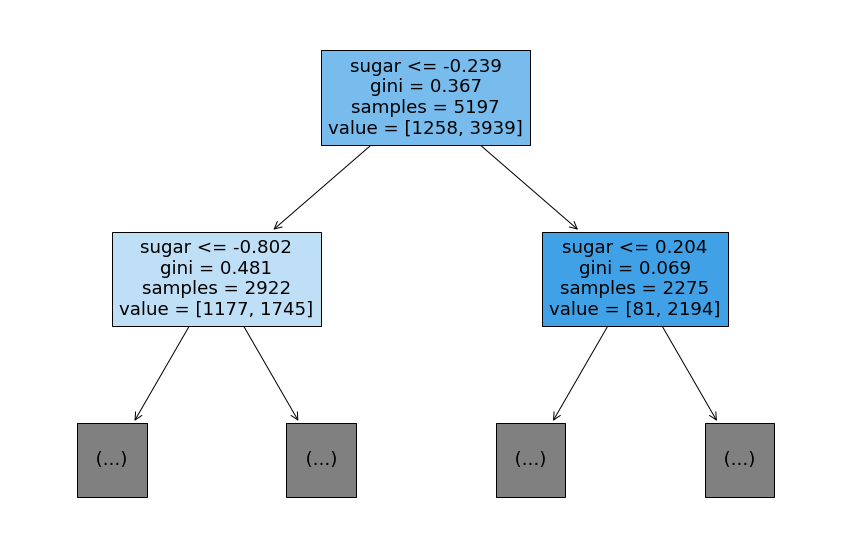

In [ ]:
plt.figure(figsize=(15,10))
plot_tree(dt, max_depth=1, filled=True, feature_names=['alcohol','sugar','pH'])
plt.show()

left branch가 YES, right branch가 NO를 의미\
gini는 불순도를 의미하며 낮을수록 한 쪽 클래스로 잘 모아졌다는 뜻\
value는 클래스별 샘플 수를 의미(gini와 연관)\
결정트리에서는 리프 노드에서 가장 많은 클래스가 **예측 클래스**가 됨


### 불순도(impurity)
- gini 불순도 : DecisionTreeClassifier의 Criterion 매개변수의 default
$$ gini\; impurity = 1-(p.class\;ratio)^2-(n.class\;ratio)^2 $$
- 결정 트리 모델은 부모 노드와 자식 노드의 impurity 차이(정보이득)가 가능한 크도록 트리를 성장
- 정보이득(information gain) : 부모 노드와 자식 노드의 impurity 차이\
IG = 부모 불순도 - (왼쪽 노드 샘플 수 / 부모 샘플 수)×왼쪽 노드 불순도 - (오른쪽 노드 샘플 수 / 부모 샘플 수)×오른쪽 노드 불순도 \

- entropy 불순도
$$ entropy = -(n.class\;ratio)×log_2(n.class\;ratio)-(p.class\;ratio)×log_2(p.class\;ratio) $$


### 가지치기
- 과최적화를 방지하고 일반화를 위해 가치지기 실행
- 가장 간단한 방법은 max_depth를 통해 최대 깊이를 제한하는 것

In [ ]:
dt = DecisionTreeClassifier(max_depth = 3, random_state =42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


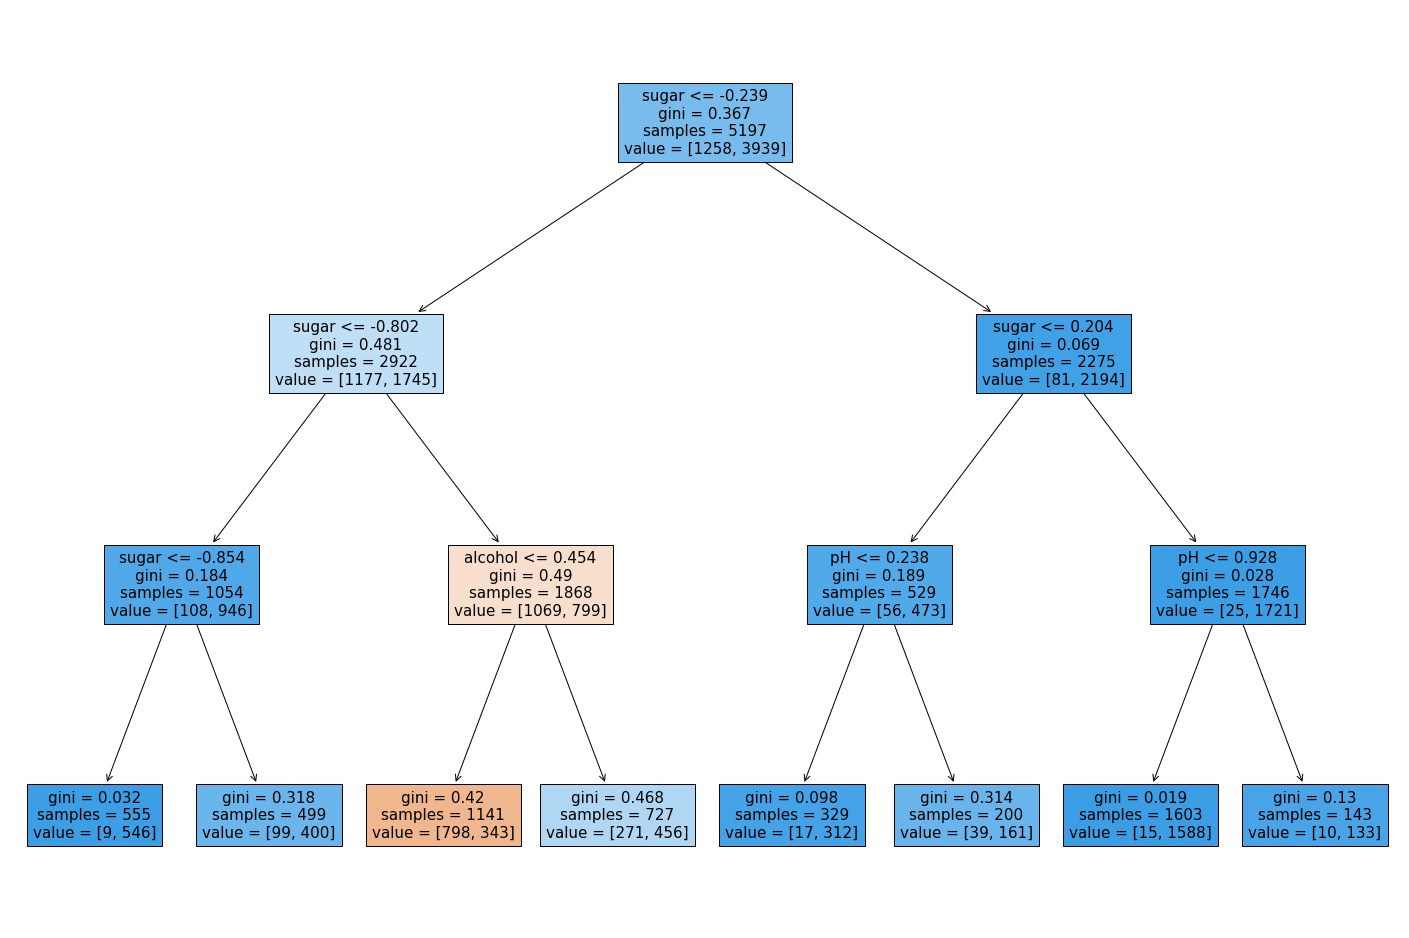

In [ ]:
plt.figure(figsize=(25, 17))
plot_tree(dt, filled=True, feature_names=['alcohol','sugar','pH'])
plt.show()

In [ ]:
# 전처리하지 않을 경우 결과가 동일
dt=DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8454877814123533
0.8415384615384616


특성 중요도 : 어떤 특성이 가장 트리 결정에 있어 유용했는지를 나타냄 by **feature_importances_**


In [ ]:
print(dt.feature_importances_)
# 루트노드와 깊이 1에서 당도를 사용한 만큼, sugar가 86.9%로서 가장 유용한 특성으로 밝혀짐

[0.12345626 0.86862934 0.0079144 ]


# 5-2. 교차 검증과 그리드 서치


여러 hyperparameter 중 최적값을 찾기 위해 계속 tuning할 때, 이제는 test set에 과대적합할 가능성이 발생, 일반성을 높이기 위해서는 최대한 test set은 사용하지 않고 모델은 완전히 완성한 뒤에 한 번만 사용하는 것이 적절


## 검증 세트(validation set)
- test set을 사용하지 않고 이를 측정하는 간단한 방법은 train set을 검증 세트, validation set으로 나누는 것
- 일반적으로 전체 데이터의 20%는 test set, 60%는 train set, 나머지 20%는 validation set으로 사용
- train set에서 모델을 훈련하고 valid set으로 모델을 평가 → 이런 식으로 여러 parameter를 변경해가며 가장 좋은 모델을 선택 → 최종적으로 train + valid set을 합쳐 모델을 훈련 → 마지막에 test set에서 최종 점수를 평가

In [ ]:
import pandas as pd
wine = pd.read_csv("https://bit.ly/wine_csv_data")

In [ ]:
data = wine[['alcohol','sugar','pH']].to_numpy()
target = wine['class'].to_numpy()

# train vs test
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

# sub(훈련) vs val(검증)
from sklearn.model_selection import train_test_split
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


val score << sub score : 과대적합

## 교차 검증(cross validation)
- val set을 만드느라 fitting에 사용하는 데이터 수가 줄어듦, 동시에 충분한 val set을 확보해야 검증 점수가 안정적으로 유지
- 이럴 때 교차 검증을 이용, valid set을 떼어 내어 평가하는 과정을 여러 번 반복하고 그 평균을 최종 검증 점수로 사용하는 기법
- k-fold 교차 검증 : train set을 k개로 나누어 교차 검증을 실시하는 것
- sklearn의 **cross_validate()** method를 사용

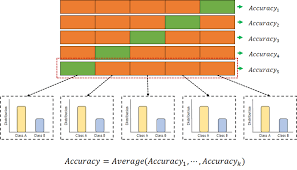

In [ ]:
from sklearn.model_selection import cross_validate
# 5-fold CV 실시
scores = cross_validate(dt, train_input, train_target) # 훈련 모형, train set을 parameter로 사용
print(scores) # dictionary 형태

{'fit_time': array([0.01696229, 0.01048779, 0.01105738, 0.01067281, 0.0101428 ]), 'score_time': array([0.00119781, 0.00107908, 0.00112605, 0.00114512, 0.00106931]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [ ]:
# 5개 점수의 평균 도출
print(sum(scores['test_score'])/scores['test_score'].shape[0])

# 다른 방법
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487
0.855300214703487


cross-validate()는 훈련 세트를 섞어 폴드를 나누지 않기에 만약 교차 검증을 할 때 훈련 세트를 섞으려면 splitter를 지정해야 함\
cross_validate() 함수는 default로 회귀 모델의 경우 KFold 분할기를, 분류 모델의 경우 StratifiedKFold를 사용

In [ ]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold()) # cv에 분할기 입력
print(np.mean(scores['test_score']))

0.855300214703487


In [ ]:
# 10-fold CV
splitter  = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼파라미터 튜닝
- 하이퍼파라미터 : 모델이 학습할 수 없어 사용자가 지정해야만 하는 파라미터
- AutoML : 사람의 개입 없이 하이퍼파라미터 튜닝을 자동으로 수행하는 기술
- Grid Search : 하이퍼파라미터 탐색과 교차 검증을 한 번에 수행. cross_validate() 함수를 호출할 필요가 없음
$$ gs = GridSearchCV(model, params) $$
 

In [ ]:
#DecisionTree에서 min_impurity_decrease 매개변수의 최적값을 찾기 위한 그리드 서치
from sklearn.model_selection import GridSearchCV
# parameter에 대해 정의역 dictionary 생성
params = {'min_impurity_decrease':[0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
# grid search에 탐색 대상 모델(DT)과 params 변수를 전달하여 그리드 서치 객체를 만듦
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

cv 매개변수 default가 5이므로 min_impurity_decrease 값마다 5-fold CV를 수행하여 25개의 모델을 훈련\
n_jobs : 병렬 실행에 사용할 CPU core 수 지정, default=1, -1은 모든 core를 사용한다는 뜻

In [ ]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

GridSearchCV는 편리하게도 25개 모델의 훈련이 끝나면 가장 검증 점수가 높은 모델의 매개변수 조합으로 전체 train set에 대해 자동으로 모델을 재훈련\
이 모델은 gs 객체의 **best_estimator_**에 저장 

In [ ]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [ ]:
# GridSearchCV로 찾은 최적의 매개변수는 gs객체의 best_params_에 저장
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [ ]:
# 각 매개변수마다 수행한 교차검증의 평균 점수(min_impurity_decrease별로 5개)는 cv_results_ 속성의 mean_test_score 키에 저장되어 있음
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [ ]:
# argmax 함수를 이용해 최적 파라미터값 반환
best_index = np.argmax(gs.cv_results_['mean_test_score'])  # 0 반환
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [ ]:
# 보다 복잡한 params 설정
params = {'min_impurity_decrease': np.linspace(0.0001, 0.0009, 9), 
          'max_depth': np.arange(5,20,1),
          'min_samples_split' : range(2,100,10)}
# 총 9 * 15 * 10 * 5 = 6750개의 모델

1. min_samples_split : 노드를 분할하기 위한 최소한의 샘플 데이터 수, default는 2, 작게 설정할수록 분할되는 노드가 많아져 과적합 가능성 증가
2. min_samples_leaf : 말단 노드가 되기 위한 최소한의 샘플 수, 비대칭적 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있어 이 경우에는 작게 설정.
3. max_features : 최적의 분할을 위해 고려할 최대 feature 개수. default는 None으로 데이터 세트의 모든 feature을 사용하여 분할
4. max_depth : 트리의 최대 깊이 지정, default는 None. 이는 완벽히 클래스 결정값이 될 때까지 깊이를 계속 키우거나 노드가 가지는 데이터 개수가 min_samples_split보다 작아질 때 까지 계속 분할

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [ ]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.00039999999999999996, 'min_samples_split': 12}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### Random Search
- parameter 값이 연속적일 때 값의 범위나 간격을 선험적으로 정하기 어려울 수 있거나 너무 많은 parameter 조건에 GridSearch가 오래 걸릴 수 있음
- 랜덤 서치는 매개변수를 샘플링할 수 있는 확률분포객체를 전달

In [ ]:
# scipy에서 2가지 확률 분포 클래스 가져오기
from scipy.stats import uniform, randint # 실수, 정수
rgen = randint(0,10)
print(rgen.rvs(5))
print(np.unique(rgen.rvs(100), return_counts=True)) # 각 숫자별 갯수까지 array로 반환
ugen = uniform(0, 1)
print(ugen.rvs(10))

[7 9 0 9 5]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([14,  5, 12, 13,  6, 13,  8,  7, 12, 10]))
[0.23192673 0.42253526 0.74901567 0.04093882 0.04220165 0.83443381
 0.28283339 0.09243867 0.33826923 0.55491768]


**RandomizedSearchCV**를 이용하여 일정한 확률 분포를 가지는 parameter의 조합을 랜덤하게 추출하여 일부만을 훈련/평가
- n_iter : 랜덤 추출하는 횟수 ($V_1 ×V_2 ×...$이라는 무한한 조합 속에서 n_iter 만큼만 추출)

In [ ]:
params = {
    'min_impurity_decrease' : uniform(0.0001, 0.001),
    'max_depth' : randint(20,50),
    'min_samples_split' : randint(2, 25),
    'min_samples_leaf' : randint(1, 25)
}

from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=500, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fecdc1c7c90>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fecdc1c7dd0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fecdc1c7990>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fecd83c7110>},
                   random_state=42)

In [ ]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))
# 최적 모델을 객체에 저장
dt = gs.best_estimator_
# test set 점수 측정
print(dt.score(test_input, test_target))

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}
0.8695428296438884
0.86


# 5-3. 트리의 앙상블


앙상블 학습(ensemble learning) : 정형데이터(excel 등을 사용할 수 있는 구조화된 데이터)를 다루는데 뛰어난 알고리즘

## 랜덤 포레스트(Random Forest)
- 결정 트리를 랜덤하게 만들어 각 트리의 예측을 통해 최종 예측
- bootstrap sampling(복원추출)을 통해 train set과 동일한 크기의 sample을 형성
- 각 node를 분할할 때 일부 특성만을 무작위로 골라 이 중에서 최선의 분할을 찾음, RandomForestClassifier는 기본적으로 노드마다 전체 특성 개수의 제곱근만큼의 특성을 랜덤하게 선택하여 사용
- sklearn의 random forest는 기본적으로 100개의 결정 트리를 이러한 방식으로 훈련
- **분류**일 때 각 트리의 클래스별 확률을 평균하여 가장 높은 확률을 가진 클래스를 예측으로 삼음 vs **회귀**일 때 단순히 각 트리의 예측을 평균
- 랜덤하게 선택한 샘플과 특성을 사용하기 때문에 train set에 과대적합되는 것을 막아주고 valid set과 test set에서 안정적인 성능을 얻는 장점

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
wine = pd.read_csv("https://bit.ly/wine_csv_data")
data = wine[['alcohol','sugar','pH']].to_numpy()
target = wine['class'].to_numpy()
train_input, test_input, train_target, test_target = train_test_split(data, target, random_state=42)

cross_validate()를 사용하여 교차 검증\
return_train_score parameter를 True로 지정하면 검증 점수뿐만 아니라 훈련 점수도 같이 반환됨, 두 점수를 통해 과대적합을 판단

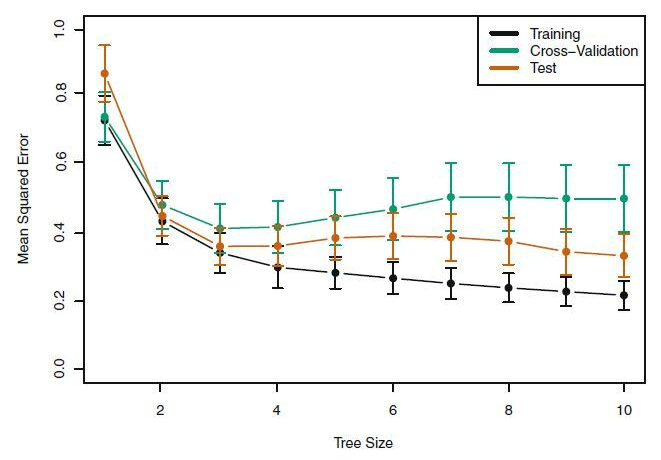

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1) #dict형태로 반환
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.997844759088341 0.8914208392565683


In [ ]:
# random forest의 특성 중요도
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.23155241 0.49706658 0.27138101]


이전의 단순 결정 트리와 비교했을 때 sugar의 중요도가 현저히 떨어진 것을 볼 수 있는데 이는 랜덤포레스트가 특성의 일부를 랜덤하게 택하여 트리를 훈련했기 때문, 이처럼 하나의 특성에 과도하게 집중하지 않고 여러 특성이 훈련에 기여할 기회를 얻음으로써 과대적합을 줄이고 일반화 성능을 높여줌

RandomForestClassifier에는 **OOB**(out of bag, bootstrap sampling에서 추출되지 못하고 남은 샘플)을 사용하여 bootstrap smp로 훈련한 결정 트리를 평가하는 기능이 있음(valid set 역할) => **oob_score**를 True로 지정\
해당 점수는 **oob_score_**에 저장됨, OOB를 사용하면 교차 검증을 대신할 수 있어 결과적으로 훈련세트에 더 많은 샘플을 사용할 수 있음

In [ ]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8981937602627258


## 엑스트라 트리

- RandomForest와 유사
- 기본적으로 100개의 결정 트리를 훈련, 전체 특성 중 일부 특성을 랜덤하게 선택하여 노드를 분할하는 데 사용
- RandomForest와 달리 bootstrap을 사용하지 않음, 대신 노드를 분할할 때 가장 좋은 분할이 아닌 무작위로 분할, 이로 인해 성능을 낮아지지만 많은 트리를 앙상블하기에 과대적합을 막고 valid set 점수를 높이는 효과가 있음
- 랜덤하게 노드를 분할하기에 계산속도가 빠름

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.997844759088341 0.8903937240035804


In [ ]:
et.fit(train_input, train_target)
print(et.feature_importances_)

[0.20702369 0.51313261 0.2798437 ]


## Gradient Boosting
- 깊이가 얕은 결정 트리를 사용하여 이전 트리의 오차를 보완하는 방법으로 앙상블 하는 기법
- sklearn의 GradientBoostingClassifier는 기본적으로 깊이가 3인 결정 트리를 100개 사용
- 깊이가 얕기에 과대적합에 강하고 높은 일반화 성능을 기대
- **경사 하강법**을 이용하여 트리를 앙상블에 추가, 결정 트리를 계속 추가하면서 cost ftn의 값을 최적화하는 작업을 실시, 따라서 깊이가 얕은 트리를 사용
- 학습률 parameter로 속도를 조절


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, n_jobs=-1, return_train_score = True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8894704231708938 0.8715107671247301


GradientBoosting은 결정 트리 개수를 늘려도 과대적합에 매우 강함!

In [ ]:
for i in range(2,7) : 
  gb = GradientBoostingClassifier(max_depth = i, random_state=42)
  scores = cross_validate(gb, train_input, train_target, n_jobs=-1, return_train_score = True)
  print("max_depth={}".format(i), np.mean(scores['train_score']), np.mean(scores['test_score']))

max_depth=2 0.8781814509668078 0.8674065181909125
max_depth=3 0.8894704231708938 0.8715107671247301
max_depth=4 0.9051211065648506 0.8768474701205708
max_depth=5 0.9312396966894981 0.8793075343547623
max_depth=6 0.9603343562090689 0.8844401621650082


- n_estimators : 결정 트리 개수
- learning_rate : 학습률

In [ ]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9512006117505237 0.879719686200179


**subsample** : 트리 훈련에 사용할 train set의 비율을 정하는 parameter, default=1, 만약 1보다 작은 값을 가지면 훈련 세트의 일부를 사용하는데 이는 확률적 경사 하강법이나 미니배치 경사 하강법과 유사한 성질

일반적으로 GB가 RF보다 조금 더 높은 성능을 보이지만 훈련속도가 느림, GB에는 n_jobs parameter가 없음

## Histogram-based Gradient Boosting
- 정형 데이터를 다루는 머신러닝 알고리즘 중 인기가 높은 알고리즘
- HGB는 입력특성을 256개의 구간으로 나눔, 따라서 노드를 분할할 떄 최적의 분할을 빠르게 찾을 수 있음
- HGB는 256개의 구간 중 하나를 떼어 놓고 누락된 값을 위해 사용하므로 입력에 누락된 특성이 있어도 이를 따로 전처리할 필요가 없음
- max_iter : n_estimators 대신 boosting 반복 횟수를 지정


In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


0.9380129799494501 0.8805410414363187


HGB의 특성 중요도를 계산하기 위해서는 permutation_importance 함수를 사용해야 하는데, 특성을 하나씩 랜덤하게 섞어서 모델의 성능이  변화하는지를 관찰하여 어떤 특성이 중요한지를 계산
- n_repeats : 랜덤하게 섞을 횟수, default=5


In [ ]:
from sklearn.inspection import permutation_importance
hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target, n_repeats= 10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.09047619 0.23316913 0.08756158]


In [ ]:
result = permutation_importance(hgb, test_input, test_target, n_repeats= 10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.04141538 0.19827692 0.03870769]


In [ ]:
hgb.score(test_input, test_target)

0.8584615384615385

In [ ]:
# XGBoost library
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8855706320776939 0.8745895856368134


In [ ]:
# LightGBM library
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9388340849212 0.8807470120570736
